# 3+ Component Mixture models and mixture weights stochastic sampling

As of the writing of this tutorial mixture models within `GammaBayes` are implemented using Dirichlet priors on the weights for each mixture, specifially the [stick-breaking process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process). The overall process for a user should not be that different to the two component case but we thought it would make it more clear if an example was given.

And just a heads up, to show the utility of this set up we need enough event numbers to see something nice, so this script could take 20+ mins to run depending on your system.

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm

from gammabayes.utils.plotting import logdensity_matrix_plot


from gammabayes.utils import logspace_simpson, convertlonlat_to_offset
from gammabayes.samplers import discrete_hyperparameter_continuous_mix_post_process_sampler

# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyper_inference import discrete_hyperparameter_likelihood
from gammabayes.priors import discrete_logprior, log_bkg_CCR_dist
from gammabayes.likelihoods.likelihood import discrete_loglikelihood
from gammabayes.dark_matter import SS_DM_dist
from gammabayes.priors.astro_sources import construct_hess_source_map_interpolation, construct_log_fermi_gaggero_bkg
from gammabayes.utils.utils import bin_centres_to_edges

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import random
random.seed(0)

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Event Simulations

We first do some simulations specifically for this script so that we explicitly show that we recover the mixture fractions that we initially set.You do not require a configuration file, but again we recommend you do so to store all the needed variables for a run. In this case we do a mix a both to show that you can even do a combination of both.

In [2]:
NumEvents                   = 500
sigfraction                 = 0.5
ccr_of_bkg_fraction         = 0.8
diffuse_of_astro_fraction   = 0.4
nsig                        = int(round(sigfraction*NumEvents))
nastrodiffuse               = int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*diffuse_of_astro_fraction*NumEvents))
nastropoint                 =int(round((1-sigfraction)*(1-ccr_of_bkg_fraction)*(1-diffuse_of_astro_fraction)*NumEvents))
nccr                        = int(round((1-sigfraction)*ccr_of_bkg_fraction*NumEvents))
print(nsig, nccr, nastrodiffuse, nastropoint,)
if nccr+nastrodiffuse+nastropoint+nsig!=NumEvents:
    print(1/0)
numcores                    = 8
truemass                    = 3.0


startertimer = time.perf_counter()
from gammabayes.utils.config_utils import create_recon_axes_from_config, create_true_axes_from_config, read_config_file

config_inputs = read_config_file('example_run_script.yaml')


energy_axis_true, longitude_axis_true, latitude_axis_true = create_true_axes_from_config(config_inputs)

energy_axis, longitude_axis, latitude_axis = create_recon_axes_from_config(config_inputs)


250 200 20 30
file path: example_run_script.yaml
0.1 100 200 0.2 -3.1 3.1 -3.0 3.0
0.1 100 50 0.4 -3.1 3.1 -3.0 3.0


We then initiate an instance of the `irf_loglikelihood` class to handle the instrument response functions, or in the Bayesian formalism _likelihoods_, for the CTA. As well as create the normalisation values for these IRFs for the analysis part of this tutorial.

In [3]:
from gammabayes.likelihoods.irfs.irf_normalisation_setup import irf_norm_setup
from gammabayes.likelihoods.irfs import irf_loglikelihood 


irf_loglike = irf_loglikelihood(zenith=20, hemisphere='S', prod_vers=5,
                               axes=(energy_axis, longitude_axis, latitude_axis), axes_names='E recon',
                               name='IRF loglikelihood',
                               dependent_axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,),
                               dependent_axes_names = ['E true', 'lon', 'lat'])

log_psfnormalisationvalues, log_edispnormalisationvalues = irf_norm_setup(energy_true_axis=energy_axis_true, energy_recon_axis=energy_axis, 
          longitudeaxistrue=longitude_axis_true, longitudeaxis=longitude_axis, latitudeaxistrue=latitude_axis_true, latitudeaxis=latitude_axis,
          log_psf=irf_loglike.log_psf, log_edisp=irf_loglike.log_edisp,)


Path to irf fits file: /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data/irf_fits_files/prod5/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz

Number of input dimensions 3
Save directory is /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data


Setting up edisp normalisation: 100%|█████████| 601/601 [00:15<00:00, 39.18it/s]


### Background setup

We then need to define what we will be fitting __to__, in this case we split the background component into 3 parts: diffuse astrophysical gamma ray sources, localised or point gamma ray sources and the background of misidentifying charged cosmic rays as gamma rays.

In [4]:
diffuse_astro_bkg_prior = discrete_logprior(logfunction=construct_log_fermi_gaggero_bkg(log_aeff=irf_loglike.log_aeff), name='Diffuse Astrophysical Background Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy', 'lon', 'lat'])


In [5]:
point_astro_bkg_prior = discrete_logprior(logfunction=construct_hess_source_map_interpolation(), name='Point Source Astrophysical Background Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy', 'lon', 'lat'],)


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


In [6]:
ccr_bkg_prior = discrete_logprior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy', 'lon', 'lat'], )

### Signal Setup

If we have a background we must then have a signal, which in this case will be the Z2 scalar singlet model, where a single field is introduced to the universe to explain dark matter. The true mass is defined as being 3 TeV above.

Construction of this prior is broken into two parts, generating the function that will take in the dark matter hyperparameters and pump out the log-probability or log-rate using `SS_DM_dist` the result of which is then inserted into the `discrete_logprior` class.

In [33]:
SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true, density_profile='nfw')
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [8]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truemass,), hyperparameter_names=['mass'],)
DM_prior

discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x1595da340>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

Now that we have defined our `discrete_logpriors` all we have to do is call the `sample` method with the number of events that we wish to simulate.

In [9]:
sig_energy_vals,siglonvals,siglatvals                                   = DM_prior.sample(nsig)
ccr_energy_vals,ccrlonvals,ccrlatvals                                   = ccr_bkg_prior.sample(nccr)
diffuse_astro_energy_vals,diffuse_astrolonvals,diffuse_astrolatvals     = diffuse_astro_bkg_prior.sample(nastrodiffuse)
point_astro_energy_vals,point_astrolonvals,point_astrolatvals           = point_astro_bkg_prior.sample(nastropoint)

It is generally a good idea to plot your results or have the values handy so that you can debug problems if they occur later on.

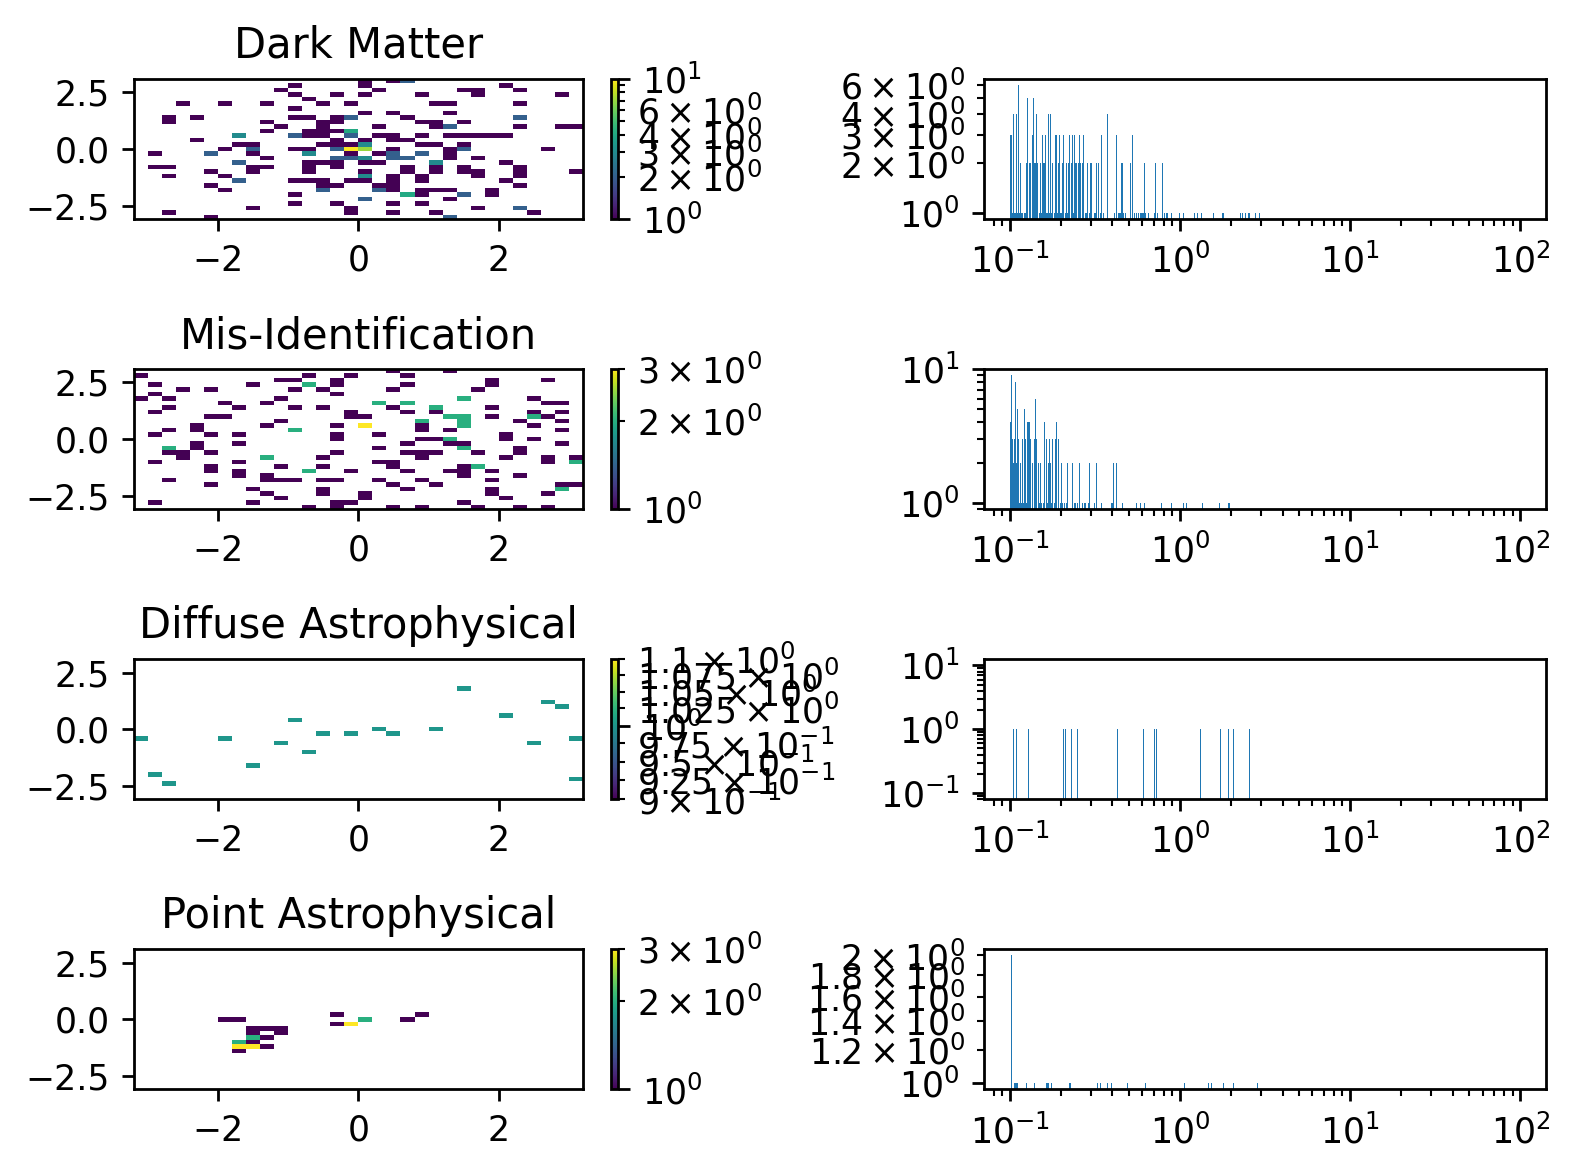

In [10]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(siglonvals,siglatvals, bins=(bin_centres_to_edges(longitude_axis_true), bin_centres_to_edges(latitude_axis_true)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(sig_energy_vals, bins=bin_centres_to_edges(energy_axis_true))
plt.loglog()

plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccrlonvals,ccrlatvals, bins=(bin_centres_to_edges(longitude_axis_true), bin_centres_to_edges(latitude_axis_true)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccr_energy_vals, bins=bin_centres_to_edges(energy_axis_true))
plt.loglog()

plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astrolonvals,diffuse_astrolatvals, bins=(bin_centres_to_edges(longitude_axis_true), bin_centres_to_edges(latitude_axis_true)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astro_energy_vals, bins=bin_centres_to_edges(energy_axis_true))
plt.loglog()

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astrolonvals,point_astrolatvals, bins=(bin_centres_to_edges(longitude_axis_true), bin_centres_to_edges(latitude_axis_true)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astro_energy_vals, bins=bin_centres_to_edges(energy_axis_true))
plt.loglog()



plt.tight_layout()
plt.show()

It looks a little sad because we aren't simulating many event to decrease the comp time of this notebook.

## Reconstructed Value Simulation

From here we inject 'noise' to create semi-realistic observation data by the CTA using the Instrument Response Functions, currently contained within the `irf_loglike` variable by sampling the produced probability density curve given the true values generated in the above simulations. We have to do this sampling recursively for every individual event, as the produced probability density is different for every unique value of the true values.

### Signal

In [11]:
signal_energy_measured, signal_lon_measured, signal_lat_measured = np.asarray([np.squeeze(irf_loglike.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(sig_energy_vals, np.array([siglonvals, siglatvals]).T), total=nsig)]).T

100%|██████████| 250/250 [00:07<00:00, 32.82it/s]


### Background

In [12]:
diffuse_astro_energy_measured, diffuse_astro_lon_measured, diffuse_astro_lat_measured = np.array([np.squeeze(irf_loglike.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(diffuse_astro_energy_vals, np.array([diffuse_astrolonvals, diffuse_astrolatvals]).T), total=nastrodiffuse)]).T

100%|██████████| 20/20 [00:00<00:00, 32.71it/s]


In [13]:
point_astro_energy_measured, point_astro_lon_measured, point_astro_lat_measured = np.array([np.squeeze(irf_loglike.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(point_astro_energy_vals, np.array([point_astrolonvals, point_astrolatvals]).T), total=nastropoint)]).T

100%|██████████| 30/30 [00:00<00:00, 32.90it/s]


In [14]:
ccr_energy_measured, ccr_lon_measured, ccr_lat_measured = np.array([np.squeeze(irf_loglike.sample((energy_val,*coord,), numsamples=1)) for energy_val,coord  in notebook_tqdm(zip(ccr_energy_vals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]).T

100%|██████████| 200/200 [00:06<00:00, 32.62it/s]


And then we plot the results again to check that nothing has gone awry.

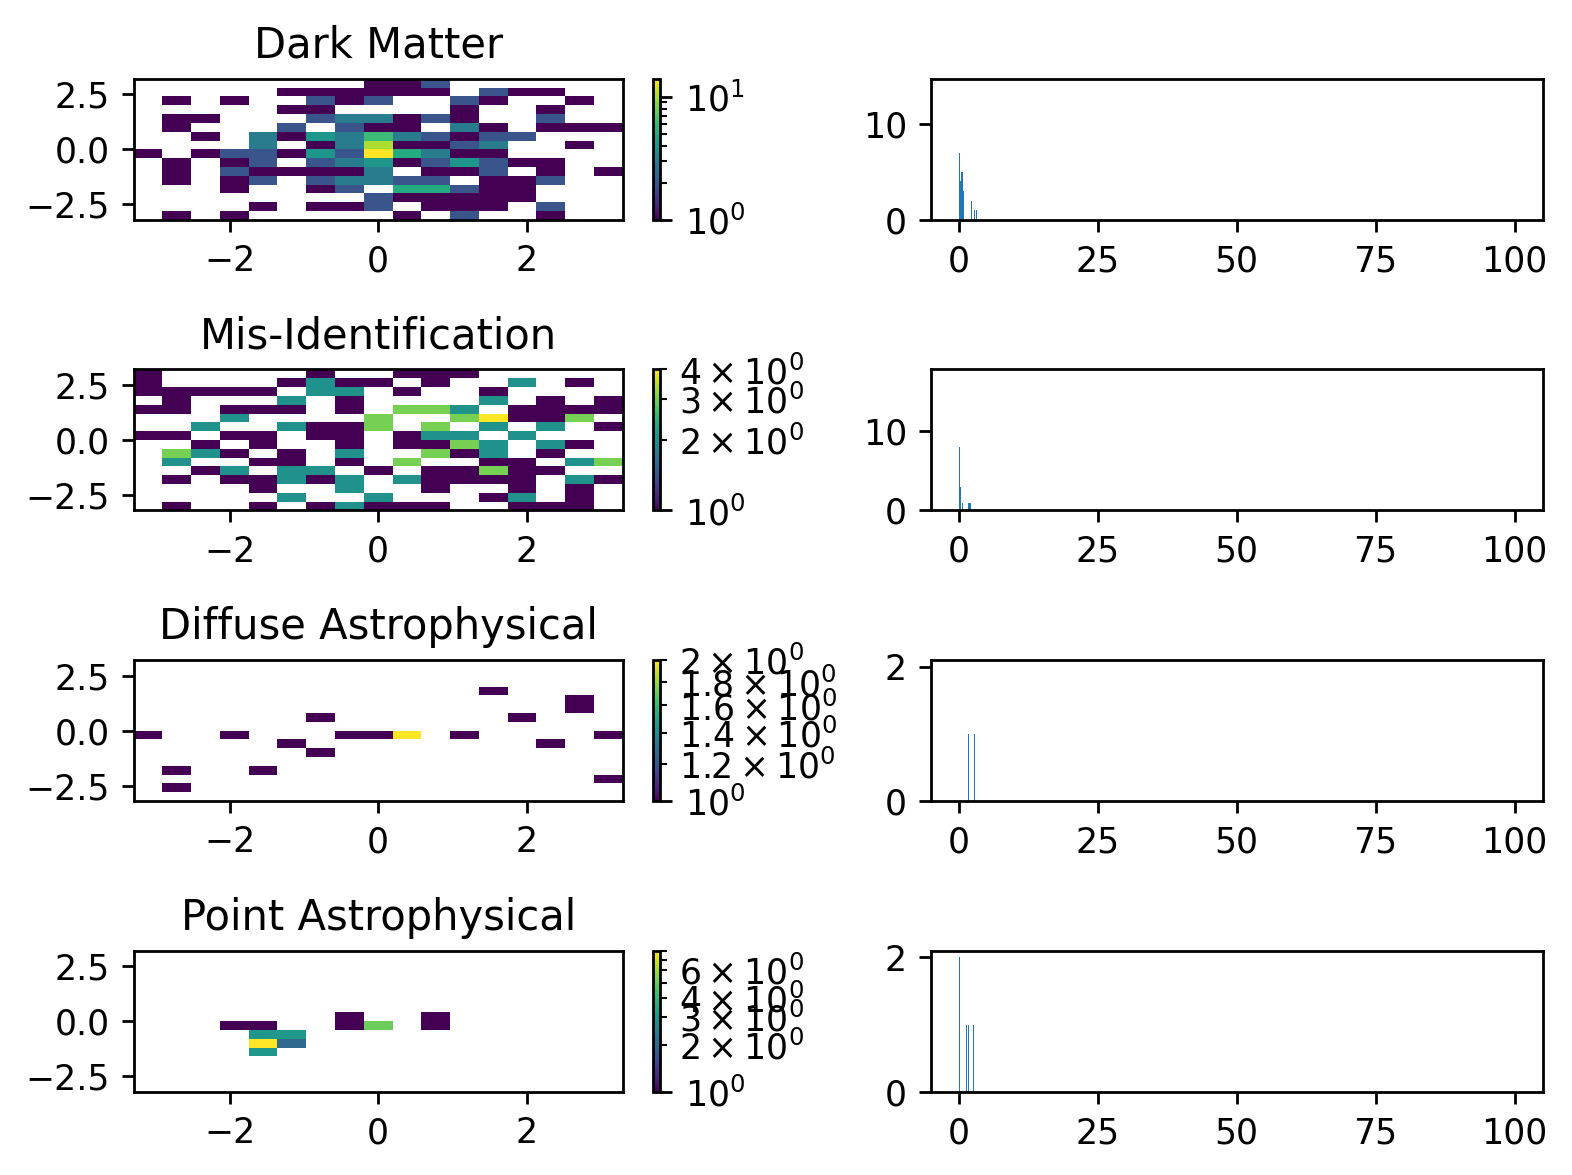

In [15]:
plt.figure(dpi=250)
plt.subplot(421)
plt.title("Dark Matter")
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(bin_centres_to_edges(longitude_axis), bin_centres_to_edges(latitude_axis)), norm=LogNorm())
plt.colorbar()

plt.subplot(422)
plt.hist(signal_energy_measured, bins=bin_centres_to_edges(energy_axis))


plt.subplot(423)
plt.title("Mis-Identification")

plt.hist2d(ccr_lon_measured, ccr_lat_measured, bins=(bin_centres_to_edges(longitude_axis), bin_centres_to_edges(latitude_axis)), norm=LogNorm())
plt.colorbar()


plt.subplot(424)
plt.hist(ccr_energy_measured, bins=bin_centres_to_edges(energy_axis))


plt.subplot(425)
plt.title("Diffuse Astrophysical")
plt.hist2d(diffuse_astro_lon_measured,diffuse_astro_lat_measured, bins=(bin_centres_to_edges(longitude_axis), bin_centres_to_edges(latitude_axis)), norm=LogNorm())
plt.colorbar()

plt.subplot(426)
plt.hist(diffuse_astro_energy_measured, bins=bin_centres_to_edges(energy_axis))

plt.subplot(427)
plt.title("Point Astrophysical")
plt.hist2d(point_astro_lon_measured,point_astro_lat_measured, bins=(bin_centres_to_edges(longitude_axis), bin_centres_to_edges(latitude_axis)), norm=LogNorm())
plt.colorbar()

plt.subplot(428)
plt.hist(point_astro_energy_measured, bins=bin_centres_to_edges(energy_axis))




plt.tight_layout()
plt.show()

## Final simulation output

We then combine all this event data together into 'measured' event data, keeping the same order so that any problems will be easier to dissect. 

In [16]:
measured_energy = list(signal_energy_measured)+list(diffuse_astro_energy_measured)+list(point_astro_energy_measured)+list(ccr_energy_measured)
measured_lon = list(signal_lon_measured)+list(diffuse_astro_lon_measured)+list(point_astro_lon_measured)+list(ccr_lon_measured)
measured_lat = list(signal_lat_measured)+list(diffuse_astro_lat_measured)+list(point_astro_lat_measured)+list(ccr_lat_measured)

# <h1><b>Analysis

Finally moving on to the analysis, we first marginalise over the nuisance parameters, being the true values of the observations, with the above priors and any hyperparameters that they use (e.g. the mass for the dark matter prior).

## Marginalisation

In [17]:
nbins_logmass = 101

if nsig is None:
    nsig = len(list(measured_energy))

logmasswindowwidth      = 8/np.sqrt(nsig)

logmasslowerbound       = np.log10(truemass)-logmasswindowwidth
logmassupperbound       = np.log10(truemass)+logmasswindowwidth

# if 1:
if logmasslowerbound<=np.log10(energy_axis)[0]:
    logmasslowerbound = np.log10(energy_axis)[1]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


massrange            = np.logspace(logmasslowerbound, logmassupperbound, nbins_logmass) 

In [18]:
hyperparameter_likelihood_instance = discrete_hyperparameter_likelihood(priors=(DM_prior, ccr_bkg_prior, diffuse_astro_bkg_prior, point_astro_bkg_prior), likelihood=irf_loglike, 
                                                               dependent_axes=(energy_axis_true, longitude_axis_true, latitude_axis_true),
                                                               hyperparameter_axes = ((massrange,), (None,), (None,), (None, )), 
                                                               numcores=numcores, likelihoodnormalisation = log_psfnormalisationvalues+log_edispnormalisationvalues)

measured_energy = [float(measured_energy_val) for measured_energy_val in measured_energy]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_energy, measured_lon, measured_lat))

prior_matrix_list does not exist. Constructing priors.


Setting up prior matrices: 100%|██████████| 4/4 [09:05<00:00, 136.30s/it]


Total cumulative number of nan values within all prior matrices: 0


/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/irf_extractor_class.py:251: RuntimeWarning: divide by zero encountered in log
  output = np.log(self.edisp_default.evaluate(energy_true=true_energy.flatten()*u.TeV,
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/irf_extractor_class.py:265: RuntimeWarning: divide by zero encountered in log
  output+=  np.log(self.psf_default.evaluate(energy_true=true_energy*u.TeV,


In [19]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
ccrmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
diffuse_astromargresults = np.squeeze(np.vstack(margresultsarray[:,2]))
point_astromargresults = np.squeeze(np.vstack(margresultsarray[:,3]))

margresultsarray[0:10].shape

(10, 4)

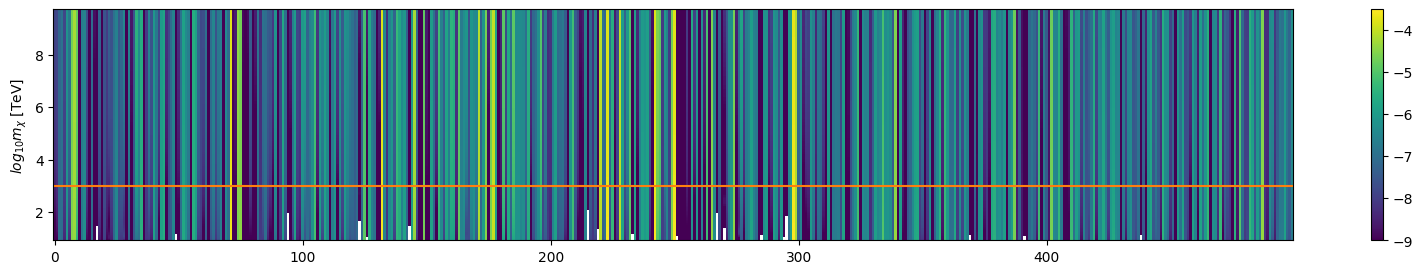

In [20]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(NumEvents)), massrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-9)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truemass, c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

So far nothing has been fundamentally different to the simple 2 component mixture model setup. Now we slightly diverge by the need to define the values that we will example for all the mixture fractions.

In [34]:
nbins_sigfrac               = 51
sigfrac_windowwidth         = 10/np.sqrt(NumEvents)
ccrfrac_windowwidth         = 8/np.sqrt(NumEvents)
diffusefrac_windowwidth     = 20/np.sqrt(NumEvents)

nbins_ccr_frac              = 51
nbins_diffuse_frac          = 51

sigfrac_range_upperbound = sigfraction+sigfrac_windowwidth
sigfrac_range_lowerbound = sigfraction-sigfrac_windowwidth



if sigfrac_range_upperbound>1:
    sigfrac_range_upperbound = 1
if sigfrac_range_lowerbound<0:
    sigfrac_range_lowerbound = 0

ccrfrac_of_bkg_range_upperbound = ccr_of_bkg_fraction+ccrfrac_windowwidth
ccrfrac_of_bkg_range_lowerbound = ccr_of_bkg_fraction-ccrfrac_windowwidth

if ccrfrac_of_bkg_range_upperbound>1:
    ccrfrac_of_bkg_range_upperbound = 1
if ccrfrac_of_bkg_range_lowerbound<0:
    ccrfrac_of_bkg_range_lowerbound = 0

diffusefrac_of_astro_range_upperbound = diffuse_of_astro_fraction+diffusefrac_windowwidth
diffusefrac_of_astro_range_lowerbound = diffuse_of_astro_fraction-diffusefrac_windowwidth


if diffusefrac_of_astro_range_upperbound>1:
    diffusefrac_of_astro_range_upperbound = 1
if diffusefrac_of_astro_range_lowerbound<0:
    diffusefrac_of_astro_range_lowerbound = 0


sigfracrange = np.linspace(sigfrac_range_lowerbound,    sigfrac_range_upperbound,   nbins_sigfrac)
ccrfrac_of_bkg_range = np.linspace(ccrfrac_of_bkg_range_lowerbound,ccrfrac_of_bkg_range_upperbound , nbins_ccr_frac)
diffuse_of_astro_range = np.linspace(diffusefrac_of_astro_range_lowerbound,diffusefrac_of_astro_range_upperbound, nbins_diffuse_frac)
mixtureaxes = sigfracrange, ccrfrac_of_bkg_range, diffuse_of_astro_range


Once we have these we can pump them into the `mixture_axes` argument of the `create_discrete_mixture_log_hyper_likelihood` method on the `discrete_hyperparameter_likelihood` class. To reduce the needed RAM for this calculation we process the events in 'chunks' of 10 specified by the `skip_factor` variable to calculate the _hyperparameter likelihood_ not necessarily the posterior, where one would need to apply the relevant priors. In our case we assume un-informative priors on every hyperparameter so the _hyperparameter likelihood_ is essentially equivalent to the _hyperparameter posterior_ up to some constant ratio.

In [35]:
skip_factor = 10
log_hyper_like = 0
loopstart = time.perf_counter()
for dataidx in tqdm(range(int(round(margresultsarray.shape[0]/skip_factor)))):
    tempmargresultsarray = margresultsarray[dataidx*skip_factor:dataidx*skip_factor+skip_factor]
    log_hyper_like += hyperparameter_likelihood_instance.create_discrete_mixture_log_hyper_likelihood(
        mixture_axes=mixtureaxes, log_margresults=tempmargresultsarray)

    

log_hyper_like_plot = log_hyper_like - special.logsumexp(log_hyper_like)

endertimer = time.perf_counter()

100%|██████████| 50/50 [08:02<00:00,  9.65s/it]


And as usual we plot these results to see how we did. 

(51,) (51,)
(51,) (51,)
(51,) (51,)
(101,) (101,)


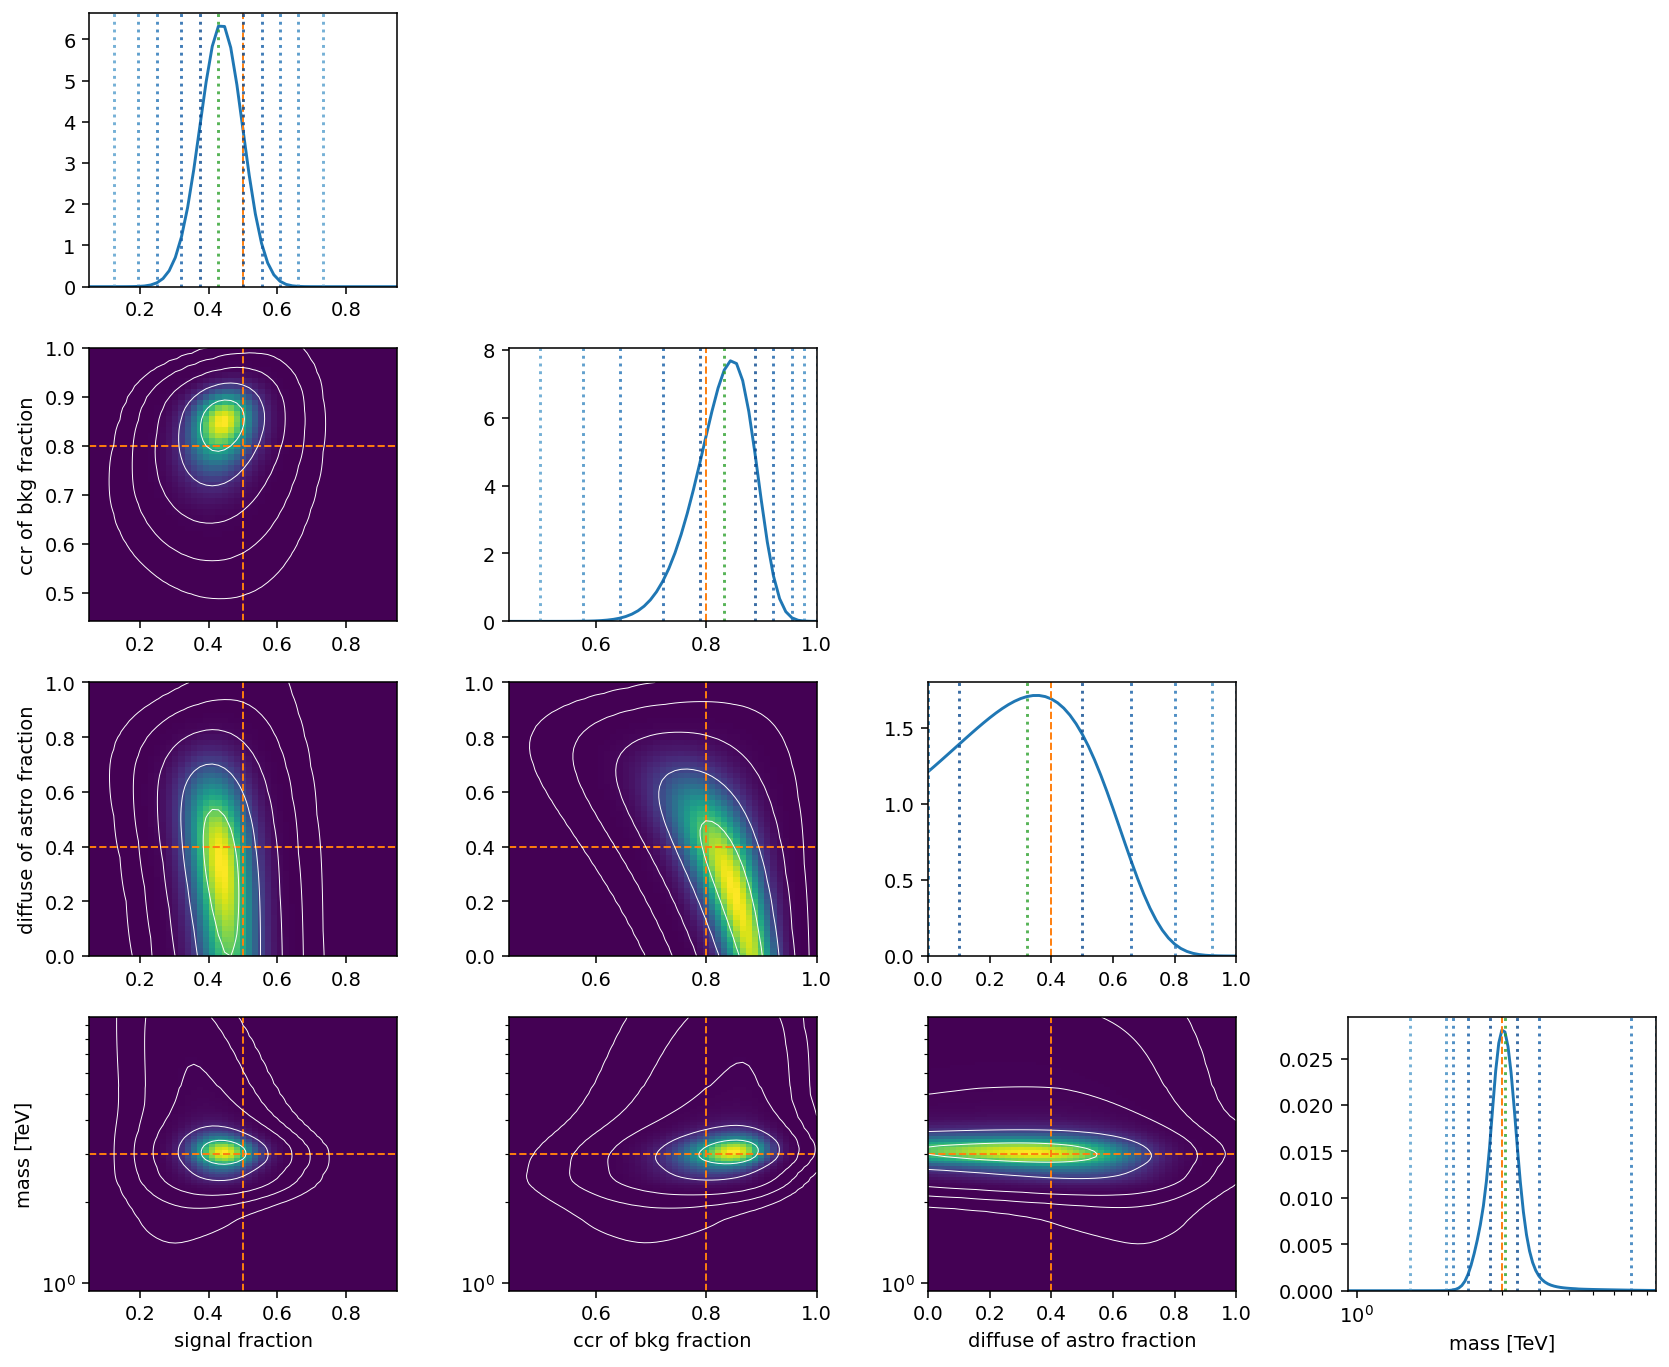

In [24]:
from gammabayes.utils.plotting import logdensity_matrix_plot
from scipy.stats import norm as norm1d
fig, ax = logdensity_matrix_plot(axes=(*mixtureaxes, massrange,), log_dist_matrix=log_hyper_like_plot-special.logsumexp(log_hyper_like_plot), 
                       truevals=(sigfraction, ccr_of_bkg_fraction, diffuse_of_astro_fraction, truemass,), contours2d=True, plot_density=True,
                       axis_names=('signal fraction', 'ccr of bkg fraction', 'diffuse of astro fraction', r'mass [TeV]', ),
                       dpi=140, figsize=(12,10), single_dim_yscales='linear')

[ax.set_yscale('log') for ax in ax[-1,:][:-1]];
ax[-1,-1].set_xscale('log')
plt.show()

## Stochastic Method for generating the hyperparameter posterior

At this level of dimensionality we already start to observe the impacts of dimensionality of our analysis when doing a brute-force scan of the parameter space. If we be a little smarter about it, we start to see benefits from using stochastic samplers, particularly __Nested Sampling__ as it allows better calculations of the _evidence_ which we previously mentioned is useful in model comparison and will discuss more after this section.

In `GammaBayes` we currently only naturally support the use of the nested sampling package `dynesty` (but the same basic principles can be applied to any nested sampler of choice) through the function `discrete_hyperparameter_continuous_mix_post_process_sampler`. The name is pretty self-explanatory but it essentially takes the same inputs as the previous method, without the need to specify the values that the mixture fractions can take, which are assumed to follow uniform priors from 0 to 1. 

It then produces samples proportional to the posterior (and the evidence if wanted). 

We first set up the class.

In [29]:
discrete_hyperparameter_continuous_mix_sampler_instance = discrete_hyperparameter_continuous_mix_post_process_sampler(
    hyper_param_ranges_tuple=((massrange,), (None,), (None,), (None,),), mixture_axes=mixtureaxes,
    margresultsarray  = margresultsarray,
    nestedsampler_kwarg_dict ={'nlive':800}
    )

The `generate_posterior` method then calculates, as you can guess, the hyperparameter posterior.

In [30]:
posterior_results = discrete_hyperparameter_continuous_mix_sampler_instance.generate_posterior(
    run_nested_kwarg_dict = {'dlogz':0.3},
    )

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/samplers/dynesty/discrete_continuous_mix_samplers.py:88: UserWarning: Calculating hyper log-likelihood with multiprocessing.
  warnings.warn("Calculating hyper log-likelihood with multiprocessing.")
4174it [05:39, 12.30it/s, +500 | bound: 14 | nc: 1 | ncall: 28190 | eff(%): 16.880 | loglstar:   -inf < -2964.214 <    inf | logz: -2971.296 +/-  0.112 | dlogz:  0.001 >  0.300]


We can then extract samples representative of the posterior and use the python function `corner` from the `corner` python package (unfortunate naming) to have a look at a good approximation of the posterior.

In [36]:
posterior_results_equal = posterior_results.samples_equal()

[(0, 0.8821547251062701), (0.4311357245341487, 1), (0, 1), (0, 1)]


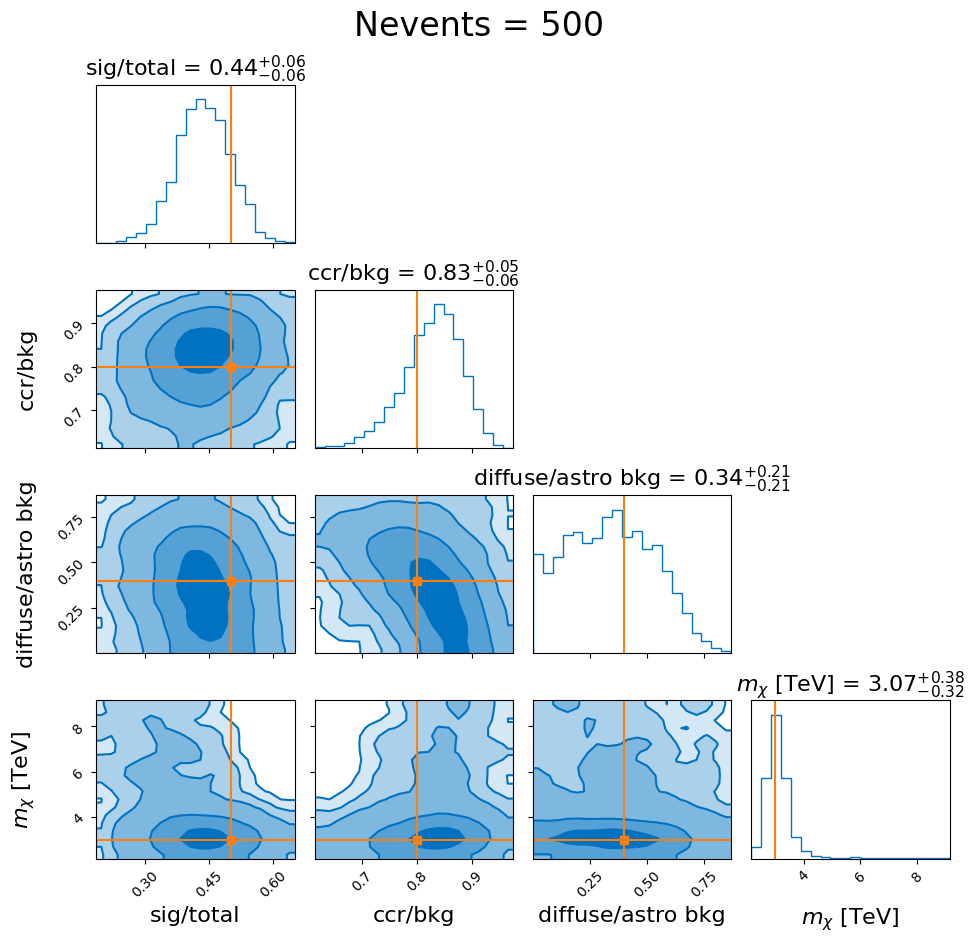

In [37]:
from corner import corner

from gammabayes.utils.plotting import defaults_kwargs

ranges = [(min(posterior_results_equal[:, i])-0.5*np.ptp(posterior_results_equal[:, i]), 
           max(posterior_results_equal[:, i])+0.5*np.ptp(posterior_results_equal[:, i]),
           ) for i in range(posterior_results_equal.shape[1])]


for idx, range_idx in enumerate(ranges):
    if not(min(posterior_results_equal[:, idx])<0):
        if range_idx[0]<0 and range_idx[1]>1:
            ranges[idx] = (0,1)
        elif range_idx[0]<0:
            ranges[idx] = (0,range_idx[1])
        else:
            ranges[idx] = (range_idx[0], 1)



print(ranges)

fig = corner(posterior_results_equal,# range=ranges,
    labels=['sig/total', 'ccr/bkg','diffuse/astro bkg', r'$m_\chi$ [TeV]'],
     show_titles=True, truths =(sigfraction, ccr_of_bkg_fraction, diffuse_of_astro_fraction,truemass),  **defaults_kwargs)
axes = fig.axes
plt.suptitle(f"Nevents = {NumEvents}", size=24)
plt.tight_layout()
plt.show()

For this specific example this sampler was quicker than the brute force approach, even if we cheat a little and look at likely regions of the mixture parameter space, and this problem only becomes worse when one of the mixture is very constrained (e.g. a realistic dark matter signal fraction) and the brute force approach would need an even higher resolution to be sure it picks up the peak. With the sampling not much would change.